In [5]:
# iloc not include end
# loc include end

import pandas as pd

import mix as mix
import db_column_name as db

import numpy as np
pd.set_option('precision', 10)

import scipy.sparse
import pickle
import xgboost as xgb

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 7,5

# offset can be 9, 21. 33, 45, 57, 69
cn = db.ColumnName()

target_minT = pd.read_csv('./data/31286_103.csv')
mix.set_index_date(target_minT, cn.date)
target_minT = target_minT.sort_index()

X = pd.read_csv('./data/character_31286.csv')
mix.set_index_date(X, cn.date)
X = X.sort_index()

X = X.drop([cn.point], axis=1)
X = X.loc[: , [x for x in X.columns if 'avg' in x or x == cn.offset]]

X = X.groupby([X.index.year, 
           X.index.month, 
           X.index.day]).mean()

a = pd.DataFrame(X.index.tolist(), 
                 columns=['year','month','day'])
X.index = pd.to_datetime(a)

X = X.drop([cn.offset], axis=1)

target_minT.index = target_minT.index.round('D')

X[cn.value] = target_minT
X = mix.clean_dataset(X)

print(X.shape)

X['winsorized'] = X[cn.value]
for index, row in X.iterrows(): 
    
    offset_day = pd.to_timedelta(5, unit='day')
    start_date = index - offset_day
    end_date = index + offset_day
    
    s = X.loc[(X.index >= start_date) & (X.index <= end_date)]
    s = s[[cn.value]]
    
    q = s.quantile([0.05, 0.95])
    
    v = row[cn.value]
    if (v < q.iloc[0, 0] or v > q.iloc[1, 0]):
        X.drop([index], inplace=True)
    
print(X.shape)

X[cn.value] = X['winsorized']
X = X.drop(['winsorized'], axis=1)

(1810, 55)
(1345, 56)


In [6]:
# X = X[X.index.year != 2016]
print(X.shape)

(1345, 55)


In [7]:
import pywt

def idwt(cA, cD):
    return  pywt.idwt(cA, cD, wavelet='db1', mode='constant')

cA, cD = pywt.dwt(X.loc[:, cn.value].values, 
                  wavelet='db1', mode='constant')
# Approximation and detail coefficients.

cA, cD = pd.DataFrame(cA, columns=['c']), pd.DataFrame(cD, columns=['c'])

print(X.shape[0])
print(cA.shape[0])

XA = []
size_X = X.shape[0]
for i in range(0, size_X, 2):
    if i + 1 < size_X:
        #iloc not include end in slice
        XA.append(X.iloc[i:i+2].mean().values)
    else:
        XA.append(X.iloc[i].values) 
XA = pd.DataFrame(XA, columns=X.columns)
XD = X.diff(-1).fillna(0)

XA_value = XA[[cn.value]]
XA.drop([cn.value], axis=1, inplace=True)

XD_value = XD[[cn.value]]
XD.drop([cn.value], axis=1, inplace=True)

1345
673


Train size : 113 and test size : 112
Mean squared error on train 1.89558 and test 14.85584
Mean absolute error on train 0.98027 and test 2.81526
Median absolute error on train 0.79478 and test 2.09160
Train size : 225 and test size : 112
Mean squared error on train 1.88428 and test 19.56051
Mean absolute error on train 0.99761 and test 3.46302
Median absolute error on train 0.73038 and test 3.02640
Train size : 337 and test size : 112
Mean squared error on train 1.80206 and test 43.88542
Mean absolute error on train 1.01565 and test 4.41376
Median absolute error on train 0.80039 and test 2.61602
Train size : 449 and test size : 112
Mean squared error on train 1.95447 and test 57.80500
Mean absolute error on train 1.06533 and test 6.10355
Median absolute error on train 0.81486 and test 5.44658
Train size : 561 and test size : 112
Mean squared error on train 2.22334 and test 18.49143
Mean absolute error on train 1.12750 and test 3.48185
Median absolute error on train 0.86928 and test 3.2

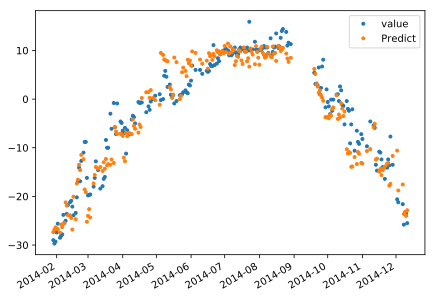

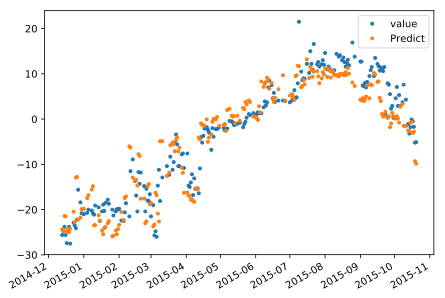

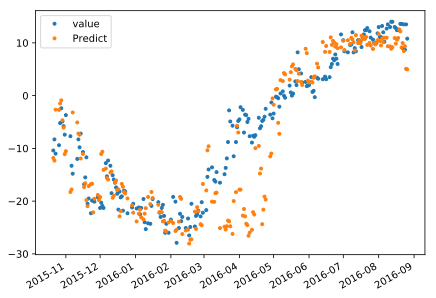

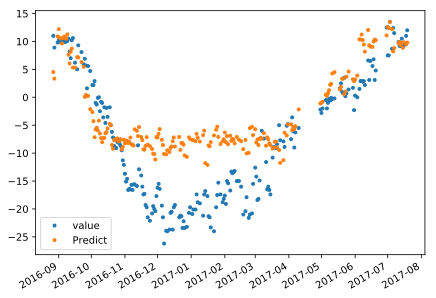

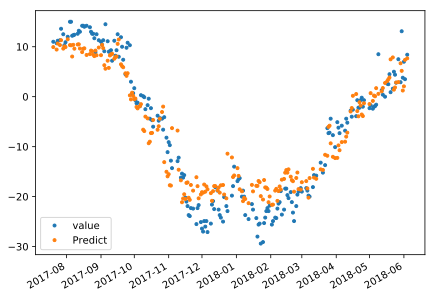

In [9]:
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

params = {
    'verbosity':0,
    'max_depth': 4,

#     'learning_rate': 0.05,
    'min_child_weight': 6,
#     'subsample':0.8, 
#     'colsample_bytree':0.8,
    'gamma': 12,
}

_, real_target = mix.getTarget(X)

for train_index, test_index in TimeSeriesSplit(5).split(XA):
    XA_train, XA_test = XA.iloc[train_index], XA.iloc[test_index]
    XD_train, XD_test = XD.iloc[train_index], XD.iloc[test_index]
    
    XA_target_train, XA_target_test = cA.iloc[train_index], cA.iloc[test_index]
    XD_target_train, XD_target_test = cD.iloc[train_index], cD.iloc[test_index]
    
    print("Train size : {} and test size : {}".format(XA_train.shape[0], XA_test.shape[0]))
    
    reg_a = xgb.XGBRegressor(**params)
    reg_a.fit(XA_train, XA_target_train.loc[:, 'c'])
    
    XA_target_test.loc[:, 'Predict'] = reg_a.predict(XA_test)
    XA_target_train.loc[:, 'Predict'] = reg_a.predict(XA_train)

    reg_d = xgb.XGBRegressor(**params)
    reg_d.fit(XD_train, XD_target_train.loc[:, 'c'])
    
    XD_target_test.loc[:, 'Predict'] = reg_d.predict(XD_test)
    XD_target_train.loc[:, 'Predict'] = reg_d.predict(XD_train)
    
    real_train = idwt(XA_target_train.loc[:, 'Predict'], XD_target_train.loc[:, 'Predict'])
    real_test = idwt(XA_target_test.loc[:, 'Predict'], XD_target_test.loc[:, 'Predict'])
    
    real_train_t = real_target.iloc[0:real_train.size].copy() # +
    real_train_t.loc[:, 'Predict'] = real_train
    
    real_test_t = real_target.iloc[real_train.size - 1:real_train.size + real_test.size - 1] # +
    real_test_t.loc[:, 'Predict'] = real_test
    
    mix.print_mean(real_test_t, real_train_t, cn.value, 'Predict') 
    real_test_t.plot(style='.')